In [31]:
%load_ext autoreload
# always reload modules marked with "%aimport"
%autoreload 1

import os,sys
import numpy as np
import pandas as pd

# add the 'src' directory as one where we can import modules
src_dir = os.path.join(os.getcwd(), '../..', 'src')
sys.path.append(src_dir)

%aimport plot_utils
from plot_utils import *
%aimport preprocessing
from preprocessing import *
%aimport data_source
from data_source import *
%aimport model_manage
from model_manage import *

import logging
from utils import *
set_logger(logging.DEBUG)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
import pandas as pd
import numpy as np

from sklearn import linear_model
from sklearn import model_selection
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet

In [33]:
import logging
set_logger(logging.DEBUG)

In [36]:
ds = DataSource(host='localhost',port=5432, username='postgres', password='', database='sdra')
ds.show_views()
#ds.update_views()

[dp] connect to database postgresql://postgres:@localhost:5432/sdra
[dp] supported views: ['properties', 'property_features', 'transactions', 'property_addresses', 'property_address_transactions', 'property_transaction_valid', 'property_address_school_transactions']


In [37]:
df_transaction = ds.get_view_df('property_address_school_transactions')
df_property = ds.get_view_df('property_addresses')
print(df_transaction.shape)
print(df_property.shape)

(1512560, 31)
(709325, 22)


In [38]:
pp = Preprocess(df_transaction, df_property, target='sold_price')

In [39]:
use_features = pp.get_feature_list()

In [40]:
# records of last year
#use_features = ['sqft', 'num_bed', 'num_bath', 'view', 'pool', 'sqft_zip_avg', 'sqft_price_zip_avg', 'sold_price_zip_avg', 'impr_over_land']
#df_track = pp.dataset(feature_set=use_features, valid=True, date=('2015-10-01', '2017-10-01'))
df_track = pp.dataset(feature='delivered', valid=True, date=('2015-10-01', '2017-10-01'))
monthly_volume = int(df_track.shape[0] / 24)
print(df_track.shape)
df_track.head()

[dp] transforming date
[dp] transforming view
[dp] transforming pool
[dp] transforming impr_over_land
[dp] transforming sold_year
[dp] transforming sold_age
[dp] making sqft_zip_avg
[dp] making sqft_price_zip_avg
[dp] making sold_price_zip_avg
[dp] making sale_count_zip
[dp] cleaning on criteria: sold_price
[dp] cleaning on criteria: sqft_price
[dp] cleaning on criteria: sqft
[dp] cleaning on criteria: num_bed
[dp] cleaning on criteria: num_bath
[dp] cleaning on criteria: lon


(68908, 18)


,sold_price,min_middle_distance,num_bed,impr_over_land,sqft_zip_avg,lon,lat,sqft_price_zip_avg,zip,sqft,pool,date,view,id,num_bath,min_elem_distance,min_high_distance,sold_price_zip_avg
0,265000,569.996198,2.0,1.667302,1436.567522,-117.02217,32.83550,284.842634,92071,908,0,2015-10-01,0,1428580,1.0,569.996198,1546.094049,399416.294643
21221,848000,3177.239859,3.0,1.207457,2395.391515,-117.24687,33.09191,325.947368,92009,2598,0,2015-10-01,1,1428693,2.0,1341.058374,2591.572639,765288.131042
11421,848000,2647.650868,4.0,0.948663,2654.883906,-117.11401,33.03887,320.782900,92127,2752,0,2015-10-01,0,1428652,2.0,1425.335222,2647.650868,848508.172674
11417,595000,1604.766621,3.0,0.700000,2654.883906,-117.11695,33.01318,320.782900,92127,1410,0,2015-10-01,0,1428591,2.0,885.148798,519.667731,848508.172674
61524,635000,375.737019,4.0,1.819159,2171.954044,-116.81683,32.83643,242.273897,91901,2711,1,2015-10-01,0,1428656,2.0,354.833180,NaN,500043.198529


## Random Forest Model

10-fold cross-validation to select the best number of trees and depth of each tree in the forest.

In [57]:
df_track.isnull().sum()

sold_price                0
min_middle_distance    2049
num_bed                   0
impr_over_land            0
sqft_zip_avg              0
lon                       0
lat                       0
sqft_price_zip_avg        0
zip                       0
sqft                      0
pool                      0
date                      0
view                      0
id                        0
num_bath                  0
min_elem_distance       648
min_high_distance      3527
sold_price_zip_avg        0
dtype: int64

In [61]:
df_track1 = df_track[np.isfinite(df_track.min_high_distance)&np.isfinite(df_track.min_middle_distance)&np.isfinite(df_track.min_elem_distance)]

In [64]:
use_features1 = use_features
use_features1.remove('min_elem_distance')
use_features1.remove('min_middle_distance')
use_features1.remove('min_high_distance')

In [65]:
use_features1

['date',
 'sqft',
 'num_bed',
 'num_bath',
 'view',
 'pool',
 'sqft_zip_avg',
 'sqft_price_zip_avg',
 'sold_price_zip_avg',
 'impr_over_land',
 'lon',
 'lat',
 'zip']

In [62]:
### segment on sold_price
rf = RandomForestRegressor(n_estimators=100, max_depth=16, n_jobs=-1, random_state=17)
mm = ModelManager(df_track1, use_features, rf, target='sold_price', time_series=True)
mm.run(sliding_window=monthly_volume*12, test_size=monthly_volume*4)

[dp] track/sliding/test window size: 53379, 34452, 11484
[dp] train/valid/test size: 42703, 10676, 11484
[dp] validation step is skipped


123884.17513401843

In [66]:
### segment on sold_price
rf = RandomForestRegressor(n_estimators=100, max_depth=16, n_jobs=-1, random_state=17)
mm = ModelManager(df_track1, use_features1, rf, target='sold_price', time_series=True)
mm.run(sliding_window=monthly_volume*12, test_size=monthly_volume*4)

[dp] track/sliding/test window size: 53379, 34452, 11484
[dp] train/valid/test size: 42703, 10676, 11484
[dp] validation step is skipped


125420.4045274722

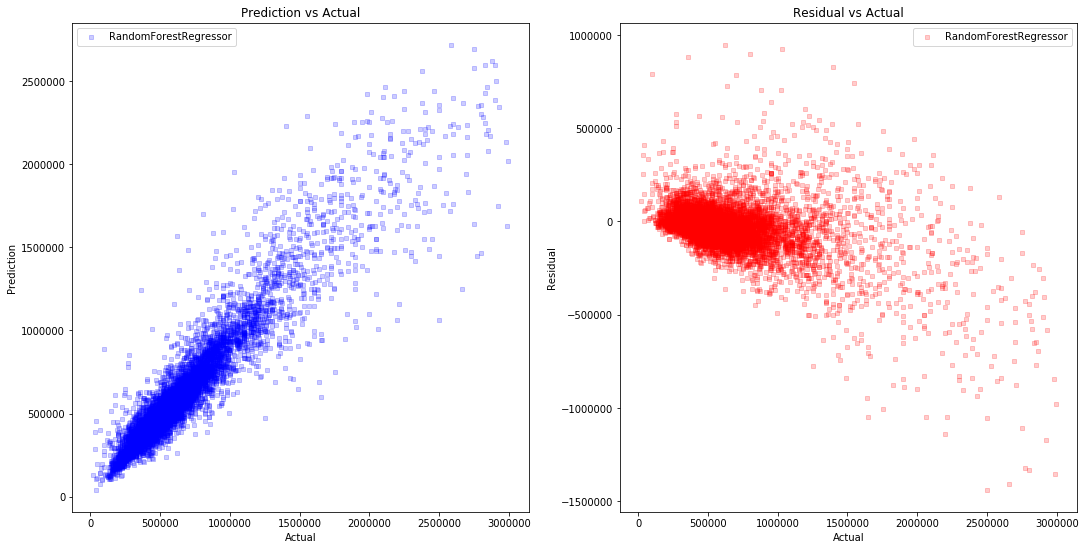

In [53]:
mm.plot_residual()

ModelType.NORMAL


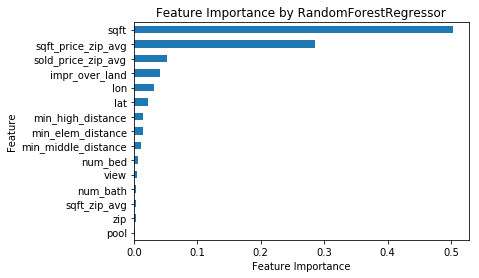

In [54]:
mm.plot_feature_importance()

In [25]:
#df_check = mm.get_result_df(pp)
df_check = pp.debug(mm.get_result_df())

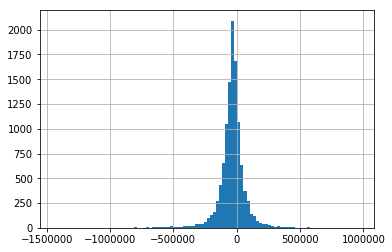

In [26]:
df_check['residual'].hist(bins=100)